In [26]:
import notebook_setup

import jax.numpy as jnp
import pandas as pd

import src.utils.pandas_utils as pdu
from src.utils.misc import generate_interval_requirements

from src.generators.shift_requirements import (
    ShiftRequirementsGenerator,
    SRGeneratorParams,
    StochasticRoundingParams,
    GradientDescentParams,
)

from src.entities.data_classes import Shift
from src.entities.shifts import RequirementShift

#### **Defining Shift Blueprints**

- **Shift list**: In order to initialize a the ShiftRequirements class we must provide a list of Shift Blueprints. They must have different names.

- **Custom coverage**: Advanced feature. Allows editing how much coverage each shift provides to the total coverage.

In [25]:
# Defining a series of shift blueprints, in this example all shifts starting an ODD hours
# and that with a duration 9 INTERVALS

db_shifts = [
    Shift(id=f"S{start:02}", task="chat", start_time=float(start), duration=9.0)
    for start in jnp.arange(0, 24, 2)
]


shifts = [
    RequirementShift(
        shift,
        daily_intervals=24,  # dividing start times in intervals of 24 hours
        coverage=jnp.ones(9) * 0.95,  # Shifts provide 95% of coverage instead of 100%
    )
    for shift in db_shifts
]

shifts[0].lower_bounds = [1, 1, 1, 1, 1, 0, 0]  # force 1 person minimum, mon to fri
shifts[1].lower_bounds = [1, 0]  # force 1 person minimum every other day

#### **Generating Shift Requirements**

- **Initialize ShiftRequirementsGenerator**: Create an instance of the class <code>ShiftRequirementsGenerator</code>.

- **Adjust Params**: We can change some og the algorythm parameters by loading a valid Params class instance using the <code>set_params</code> method.

- **Generate**: Running the <code>generate</code> method returns the an instance of <code>ShiftRequirementsghts</code>, that contains the final weights, the run parameters and the evolution of weights throughout the sub-processes.

In [22]:
# Initialize Shift Requirements
num_weeks = 4

sr_gen = ShiftRequirementsGenerator(shifts=shifts, days=num_weeks * 7)

# Custom Parameters
sr_gen.set_params(
    SRGeneratorParams(
        daily_intervals=24,
        asymetric_weight=0.75,
        gradient_descent=GradientDescentParams(
            learning_rate=1, num_iterations=5000, snapshot_length=50
        ),
        stochastic_rounding=StochasticRoundingParams(section_size=24, passes=25),
    )
)

#
int_reqs = generate_interval_requirements(
    weeks=num_weeks, base_demand=10, cycle_amplitude=7
)

# Generate Requirements
shift_reqs = sr_gen.generate(interval_reqs=int_reqs)

--- GRADIENT DESCENT ---
Iteration 0: Error = 82.66254425048828
Iteration 50: Error = 1.0333867073059082
Iteration 100: Error = 0.7622018456459045
Iteration 150: Error = 0.7245386838912964
Iteration 200: Error = 0.7081724405288696
Iteration 250: Error = 0.6982114315032959
Iteration 300: Error = 0.6912742853164673
Iteration 350: Error = 0.6861689686775208
Iteration 400: Error = 0.6822863817214966
Iteration 450: Error = 0.6792676448822021
Iteration 500: Error = 0.6768800020217896
Iteration 550: Error = 0.67496657371521
Iteration 600: Error = 0.6734174489974976
Iteration 650: Error = 0.6721579432487488
Iteration 700: Error = 0.671135425567627
Iteration 750: Error = 0.6702916622161865
Iteration 800: Error = 0.6695921421051025
Iteration 850: Error = 0.6690097451210022
Iteration 900: Error = 0.6685230731964111
Iteration 950: Error = 0.6681153178215027
Iteration 1000: Error = 0.6677731275558472
Iteration 1050: Error = 0.667485237121582
Iteration 1100: Error = 0.6672425270080566
Iteration 1150

#### Exploring Results:

Diff between GD and SR final result:
 mean -> 0.0 | sum -> 0.28


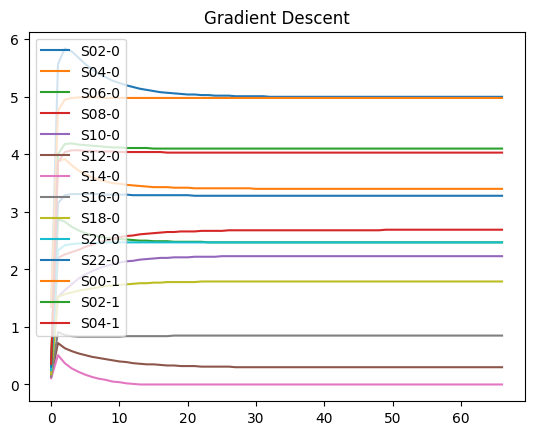

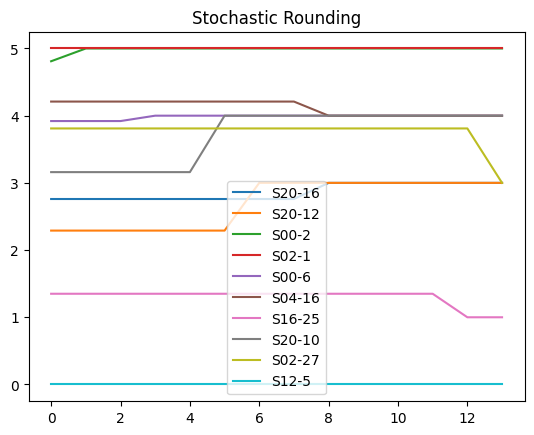

In [23]:
# Evolution DataFrames
gradient_evol_df = pdu.evolution_df("gd_evolution", shift_reqs)

stoch_round_evol_df = pdu.evolution_df("sr_evolution", shift_reqs)

# Visualize Gradient Evolution
gradient_evol_df.iloc[:, 1:15].plot(title="Gradient Descent")

# Visualize Gradient Evolution
stoch_round_evol_df.transpose().sample(10).transpose().plot(title="Stochastic Rounding")

# Last Step Comparison
last_steps_diff = stoch_round_evol_df.iloc[-1].values - gradient_evol_df.iloc[-1].values

print(
    f"Diff between GD and SR final result:\n mean -> {last_steps_diff.mean().round(2)} | sum -> {last_steps_diff.sum().round(2)}"
)

<Axes: >

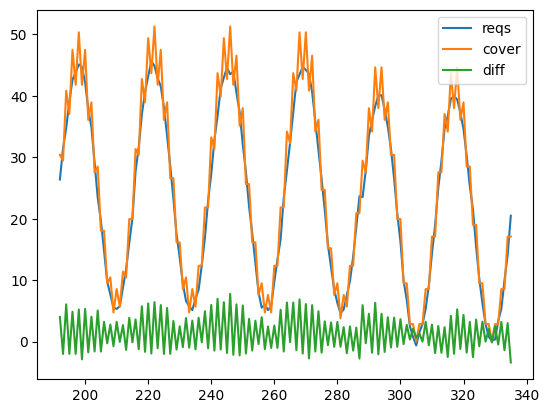

In [5]:
pdu.shift_reqs_coverage_df(shift_reqs)[24 * 8 : 24 * 14].plot()

In [24]:
pdu.shift_reqs_results_df(shift_reqs).pivot(
    columns="shift_name", index="day_index", values="req"
)

shift_name,S00,S02,S04,S06,S08,S10,S12,S14,S16,S18,S20,S22
day_index,,,,,,,,,,,,
0,10.0,5.0,3.0,2.0,3.0,3.0,0.0,0.0,1.0,2.0,2.0,3.0
1,5.0,5.0,4.0,4.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,4.0
2,5.0,5.0,4.0,3.0,2.0,2.0,1.0,0.0,1.0,2.0,2.0,4.0
3,5.0,5.0,4.0,3.0,2.0,1.0,0.0,0.0,2.0,1.0,3.0,3.0
4,5.0,5.0,4.0,3.0,2.0,1.0,0.0,0.0,1.0,2.0,2.0,4.0
5,3.0,4.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0
6,4.0,4.0,4.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0
7,5.0,4.0,4.0,3.0,3.0,2.0,0.0,0.0,1.0,2.0,2.0,4.0
8,5.0,5.0,4.0,4.0,2.0,2.0,1.0,0.0,0.0,2.0,3.0,3.0


In [17]:
pdu.shift_reqs_results_df(shift_reqs).pivot(
    index="shift_name", columns="day_index", values="req"
)

day_index,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
shift_name,,,,,,,,,,,,,,,,,,,,,
S00,25.0,12.0,12.0,12.0,12.0,9.0,10.0,12.0,12.0,12.0,...,12.0,9.0,11.0,12.0,12.0,12.0,12.0,13.0,9.0,11.0
S02,14.0,12.0,13.0,12.0,13.0,11.0,11.0,12.0,12.0,13.0,...,12.0,12.0,11.0,12.0,13.0,13.0,13.0,12.0,12.0,11.0
S04,9.0,11.0,11.0,11.0,11.0,11.0,10.0,12.0,11.0,11.0,...,10.0,10.0,10.0,11.0,11.0,11.0,10.0,11.0,10.0,10.0
S06,7.0,9.0,9.0,9.0,8.0,7.0,7.0,9.0,9.0,8.0,...,9.0,7.0,7.0,9.0,9.0,9.0,9.0,8.0,7.0,7.0
S08,7.0,5.0,6.0,5.0,5.0,3.0,3.0,6.0,6.0,6.0,...,5.0,3.0,3.0,6.0,6.0,5.0,5.0,5.0,3.0,3.0
S10,5.0,3.0,3.0,2.0,2.0,0.0,0.0,4.0,3.0,3.0,...,2.0,0.0,0.0,4.0,3.0,3.0,3.0,2.0,0.0,0.0
S12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
S14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
S16,1.0,1.0,1.0,2.0,3.0,0.0,0.0,1.0,1.0,2.0,...,2.0,0.0,0.0,1.0,1.0,2.0,2.0,3.0,0.0,2.0
